# Data Analysis

In this notebook we study the error in our numerical method as well as preform various sanity checks on the results. These are:
1. Ploting the RMSv
2. Ploting the Error in Energy Conservation as a function of timestep size
3. Generating contour plots at various timesteps to compare with the results of Schaer and Wernli's paper for the initial condition of an isolated Semi-Geostrophic Cyclone. 

### Import the needed packages 

In [1]:
import numpy as np
import time
from solvers import mainHeun as Heun
from solvers import mainRK4 as RK4
from solvers import mainAB2 as AB2
from solvers import mainCN as CN
#import erroranalysis as err
import auxfunctions as aux
import matplotlib.pyplot as plt
import random

### Load in the Data

In [ ]:
ZRef, CRef, WRef, MRef, TCRef = aux.load_data('./PaperData/RK4_SG_data_10-3_32_15.msgpack')
box = [-3.66, -1.75, 0, 3.66, 1.75, 0.45]

In [ ]:
Z1, C1, _, _, _ = aux.load_data('./PaperData/RK4_SG_data_A=-0.5.msgpack')
Z2, C2, _, _, _ = aux.load_data('./PaperData/RK4_SG_data_A=0.msgpack')
Z3, C3, _, _, _ = aux.load_data('./PaperData/RK4_SG_data_A=0.1.msgpack')
box = [-3.66, -1.75, 0, 3.66, 1.75, 0.45]

In [2]:
Z, C, W, M, TC = aux.load_data('./PaperData/RK4_SG_data_10-3_32_15.msgpack')

## Error Analysis

Here we investigate the Wasserstein-2 Distance. These are done by comparison to a "high-resolution" simulation. 

### Check the Wasserstein Distance

In [ ]:
comptimes = aux.get_comparison_indices(len(Z), len(ZRef), 52)
distances = err.Wasserstein_Distance(Z, M, ZRef, MRef, comptimes)
error = max(distances)
print(error)

In [ ]:
# Timesteps
timesteps = 52 / np.array([201, 302, 403, 604, 804, 1207])
# Error at Day 2
errors_day_2 = np.array([0.0091, 0.0022, 0.0014, 0.0007, 0.0004, 5.2552e-5])
# errors_day_4 = np.array([0.0223, 0.0071, 0.0055, 0.0032, 0.0025, 0.0017])
# errors_day_9 = np.array([0.0866, 0.0393, 0.0428, 0.0351, 0.0331, 0.0246])
# errors_day_13 = np.array([0.3650, 0.1865, 0.1645, 0.1377, 0.1433, 0.0939])
# errors_day_17 = np.array([0.6162, 0.5765, 0.6625, 0.7114, 0.3229, 0.4740])
# errors_day_21 = np.array([0.5932, 0.7715, 0.9556, 0.9401, 0.5205, 0.9702])
# errors_day_25 = np.array([0.9808, 0.8195, 0.8565, 1.0594, 0.4602, 0.6124])

# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each day's error
plt.loglog(timesteps, errors_day_2, 'o-', label='$\log W_2^2$')
# plt.loglog(timesteps, errors_day_4, 's-', label='Day 4')
# plt.loglog(timesteps, errors_day_9, 'd-', label='Day 9')
# plt.loglog(timesteps, errors_day_13, 'x-', label='Day 13')
# plt.loglog(timesteps, errors_day_17, '^-', label='Day 17')
# plt.loglog(timesteps, errors_day_21, 'v-', label='Day 21')
# plt.loglog(timesteps, errors_day_25, 'p-', label='Day 25')

# Plotting the reference line for h^4 reduction for Day 2
reference_errors_day_2 = errors_day_2[0] * (timesteps / timesteps[0])**4  # scale factor for reference line
plt.loglog(timesteps, reference_errors_day_2, '--', label='Reference: $h^4$')

# Customizing x-axis labels
labels = ['3 hr', '2 hr', '1 hr 30 m', '1 hr', '45 m', '30 m']
plt.xticks(timesteps, labels, rotation=45)  # Rotate labels to avoid overlap
plt.minorticks_off()  # Disable minor ticks

plt.xlabel('Log of Timestep Size')
plt.ylabel('Log of Wasserstein-2 Distance')
plt.title('Log-Log of Wasserstein-2 Distance with Timestep Size at Day 2')
plt.grid(True, which="both", ls="--")

# Placing the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

# Save the plot as a PNG file with DPI=300
plt.savefig('TimeError.png', dpi=300)

plt.show()

In [ ]:
# Timesteps
timesteps = 52 / np.array([201, 302, 403, 604, 804, 1207])

# Days
days = np.array([2, 4, 9, 13, 17, 21, 25])

# Errors
errors_day_2 = np.array([0.0091, 0.0022, 0.0014, 0.0007, 0.0004, 5.2552e-5])
errors_day_4 = np.array([0.0223, 0.0071, 0.0055, 0.0032, 0.0025, 0.0017])
errors_day_9 = np.array([0.0866, 0.0393, 0.0428, 0.0351, 0.0331, 0.0246])
errors_day_13 = np.array([0.3650, 0.1865, 0.1645, 0.1377, 0.1433, 0.0939])
errors_day_17 = np.array([0.6162, 0.5765, 0.6625, 0.7114, 0.3229, 0.4740])
errors_day_21 = np.array([0.5932, 0.7715, 0.9556, 0.9401, 0.5205, 0.9702])
errors_day_25 = np.array([0.9808, 0.8195, 0.8565, 1.0594, 0.4602, 0.6124])

# Combine all errors into a single array for easier plotting
errors = np.array([errors_day_2, errors_day_4, errors_day_9, errors_day_13, errors_day_17, errors_day_21, errors_day_25])

# Take the log of the errors
log_errors = np.log10(errors)

# Reference error behavior: h^4 reduction
initial_error = errors_day_2[0]
reference_errors = np.zeros_like(errors)
for i in range(len(timesteps)):
    reference_errors[:, i] = initial_error * (timesteps[i] / timesteps[0])**4

# Take the log of the reference errors
log_reference_errors = np.log10(reference_errors)

# Calculate the difference between actual errors and reference errors
log_difference_errors = log_errors - log_reference_errors

# Determine the color limits based on the combined range of log_errors, log_reference_errors, and log_difference_errors
vmin = min(np.min(log_errors), np.min(log_reference_errors), np.min(log_difference_errors))
vmax = max(np.max(log_errors), np.max(log_reference_errors), np.max(log_difference_errors))

# Create a 2D heatmap with shared color bar
fig, axs = plt.subplots(1, 3, figsize=(30, 6))

# Plot the original heatmap with log(errors)
c1 = axs[0].imshow(log_errors, aspect='auto', interpolation='nearest', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
axs[0].set_xlabel('Log of Timestep size')
axs[0].set_ylabel('Days')
axs[0].set_title('Log of Error')
axs[0].set_xticks(np.arange(len(timesteps)))
axs[0].set_xticklabels(np.log10(timesteps).round(2))
axs[0].set_yticks(np.arange(len(days)))
axs[0].set_yticklabels(days)

# Plot the reference heatmap with log(reference errors)
c2 = axs[1].imshow(log_reference_errors, aspect='auto', interpolation='nearest', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
axs[1].set_xlabel('Log of Timestep size')
axs[1].set_ylabel('Days')
axs[1].set_title('Log of Reference Error')
axs[1].set_xticks(np.arange(len(timesteps)))
axs[1].set_xticklabels(np.log10(timesteps).round(2))
axs[1].set_yticks(np.arange(len(days)))
axs[1].set_yticklabels(days)

# Plot the difference heatmap with log(difference errors)
c3 = axs[2].imshow(log_difference_errors, aspect='auto', interpolation='nearest', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
axs[2].set_xlabel('Log of Timestep size')
axs[2].set_ylabel('Days')
axs[2].set_title('Log of Difference between Actual and Reference Error')
axs[2].set_xticks(np.arange(len(timesteps)))
axs[2].set_xticklabels(np.log10(timesteps).round(2))
axs[2].set_yticks(np.arange(len(days)))
axs[2].set_yticklabels(days)

# Create a single color bar for all three plots
cbar = fig.colorbar(c1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Log of Error')

plt.show()

In [ ]:
# Number of particles
particles = np.array([4096, 5832, 10648, 21952])

# Errors at different days
errors_day_2 = np.array([0.1600, 0.1233, 0.0699, 0.0246])
# errors_day_4 = np.array([0.2594, 0.1503, 0.0939, 0.0315])
# errors_day_9 = np.array([0.6186, 0.4656, 0.3040, 0.1190])
# errors_day_13 = np.array([1.3901, 1.0459, 0.5674, 0.7100])
# errors_day_17 = np.array([1.8708, 1.4215, 0.9495, 0.7642])
# errors_day_21 = np.array([1.9466, 1.3115, 1.2798, 1.4379])
# errors_day_25 = np.array([1.4330, 0.8541, 0.9993, 0.8179])

# Reference line for perfect halving behavior
reference_errors = errors_day_2[0] * (particles[0] / particles)**(2/3)

# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each day's error
plt.loglog(particles, errors_day_2, 'o-', label='$\log W_2^2$')
# plt.loglog(particles, errors_day_4, 's-', label='Day 4')
# plt.loglog(particles, errors_day_9, 'd-', label='Day 9')
# plt.loglog(particles, errors_day_13, 'x-', label='Day 13')
# plt.loglog(particles, errors_day_17, '^-', label='Day 17')
# plt.loglog(particles, errors_day_21, 'v-', label='Day 21')
# plt.loglog(particles, errors_day_25, 'p-', label='Day 25')

# Plotting the reference line for perfect halving behavior
plt.loglog(particles, reference_errors, '--', label='Reference: $N^{-2/3}$')

# Customizing x-axis labels to be the number of particles
plt.xticks(particles, particles, rotation=45)  # Rotate labels to avoid overlap
plt.minorticks_off()  # Disable minor ticks

plt.xlabel('Log of Number of Particles')
plt.ylabel('Log of Wasserstein-2')
plt.title('Log-Log of Wasserstein-2 Distance with Particle Count at Day 2')
plt.grid(True, which="both", ls="--")

# Placing the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

# Save the plot as a PNG file with DPI=300
plt.savefig('ParticleError.png', dpi=300)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of particles
particles = np.array([4096, 5832, 10648, 21952])

# Days
days = np.array([2, 4, 9, 13, 17, 21, 25])

# Errors at different days
errors_day_2 = np.array([0.1600, 0.1233, 0.0699, 0.0246])
errors_day_4 = np.array([0.2594, 0.1503, 0.0939, 0.0315])
errors_day_9 = np.array([0.6186, 0.4656, 0.3040, 0.1190])
errors_day_13 = np.array([1.3901, 1.0459, 0.5674, 0.7100])
errors_day_17 = np.array([1.8708, 1.4215, 0.9495, 0.7642])
errors_day_21 = np.array([1.9466, 1.3115, 1.2798, 1.4379])
errors_day_25 = np.array([1.4330, 0.8541, 0.9993, 0.8179])

# Combine all errors into a single array for easier plotting
errors = np.array([errors_day_2, errors_day_4, errors_day_9, errors_day_13, errors_day_17, errors_day_21, errors_day_25])

# Take the log of the errors
log_errors = np.log10(errors)

# Reference error behavior: error decreases as N^(-1/2)
reference_errors = np.zeros_like(errors)
for i in range(len(particles)):
    reference_errors[:, i] = errors_day_2[0] * (particles[0] / particles[i])**0.5

# Take the log of the reference errors
log_reference_errors = np.log10(reference_errors)

# Calculate the difference between actual errors and reference errors
log_difference_errors = log_errors - log_reference_errors

# Determine the color limits based on the combined range of log_errors, log_reference_errors, and log_difference_errors
vmin = min(np.min(log_errors), np.min(log_reference_errors), np.min(log_difference_errors))
vmax = max(np.max(log_errors), np.max(log_reference_errors), np.max(log_difference_errors))

# Create a 2D heatmap with shared color bar
fig, axs = plt.subplots(1, 3, figsize=(30, 6))

# Plot the original heatmap with log(errors)
c1 = axs[0].imshow(log_errors, aspect='auto', interpolation='nearest', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
axs[0].set_xlabel('Log of Number of Particles')
axs[0].set_ylabel('Days')
axs[0].set_title('Log of Error')
axs[0].set_xticks(np.arange(len(particles)))
axs[0].set_xticklabels(np.log10(particles).round(2))
axs[0].set_yticks(np.arange(len(days)))
axs[0].set_yticklabels(days)

# Plot the reference heatmap with log(reference errors)
c2 = axs[1].imshow(log_reference_errors, aspect='auto', interpolation='nearest', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
axs[1].set_xlabel('Log of Number of Particles')
axs[1].set_ylabel('Days')
axs[1].set_title('Log of Reference Error')
axs[1].set_xticks(np.arange(len(particles)))
axs[1].set_xticklabels(np.log10(particles).round(2))
axs[1].set_yticks(np.arange(len(days)))
axs[1].set_yticklabels(days)

# Plot the difference heatmap with log(difference errors)
c3 = axs[2].imshow(log_difference_errors, aspect='auto', interpolation='nearest', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
axs[2].set_xlabel('Log of Number of Particles')
axs[2].set_ylabel('Days')
axs[2].set_title('Log of Difference between Actual and Reference Error')
axs[2].set_xticks(np.arange(len(particles)))
axs[2].set_xticklabels(np.log10(particles).round(2))
axs[2].set_yticks(np.arange(len(days)))
axs[2].set_yticklabels(days)

# Create a single color bar for all three plots
cbar = fig.colorbar(c1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Log of Error')

plt.show()

## Next we have our coding sanity checks

### Check the RMSv

In [ ]:
# Define the datasets
datasets = [(Z1, C1), (Z2, C2), (Z3, C3)]
colors = ['red', 'blue', 'green']
labels = ['A=-0.5', 'A=0', 'A=0.1']

# A list of the three types to plot
types = ['Zonal', 'Meridional', 'Total']

# Calculate the number of timesteps based on one of the datasets (assuming all have the same length)
timesteps = np.arange(len(Z1))

# Convert timesteps to days (each timestep is 30 minutes, hence divide by 48)
days = timesteps / 48

for plot_type in types:
    plt.figure()  # Create a new figure for each type of velocity
    for (ZRef, CRef), color, label in zip(datasets, colors, labels):
        # Calculate RMS velocity for the current type
        RMSv = err.Root_Mean_Squared_Velocity(ZRef, CRef, plot_type)
        
        # Create a line plot
        plt.plot(days, RMSv, color=color, label=label)
    
    # Add labels and title
    plt.xlabel('Days')
    plt.ylabel(f'{plot_type} RMSv')
    plt.title(f'{plot_type} RMSv Over Time')
    
    # Add legend to differentiate the datasets
    plt.legend()
    
    # Save the plot as a PNG file with DPI=300
    plt.savefig(f'RMSv_{plot_type}.png', dpi=300)
    
    # Optionally, show the plot
    plt.show()


### Checking that the Transport Cost is Conserved

In [ ]:
# Define dictionary for maping files
solver_name_map = {
    AB2: 'AB2',
    Heun: 'Heun',
    RK4: 'RK4',
    CN: 'CN'
}

# Define the parameters of the system
box = [-2, -1, 0, 2, 1, 0.5] # List or tuple defining domain [xmin, ymin, zmin, xmax, ymax, zmax]
per_tol = 1e-3 # Percent tolerance
per_x = True # Set the periodicity of X
per_y = False # Set the periodicity of Y
per_z = False # Set the periodicity of Z
tf = 26 # Final time
Ndt = np.linspace(20, 2000, 20, endpoint=True) # Number of timesteps
N = 10 # Number of seeds
Z = np.array([(random.uniform(box[0], box[3]),
               random.uniform(box[1], box[4]),
               random.uniform(box[2], box[5])) for _ in range(N)]) # Place the seeds randomly

# Function to run a solver test and compute metrics
def run_test(solver, box, Z, per_tol, tf, Ndt, per_x, per_y, per_z, debug=False):
    """
    Runs a specific solver and returns conservation error and runtime.

    Parameters:
    - solver: The solver function to run.
    - box, Z, per_tol, tf, Ndt, per_x, per_y, per_z: Parameters for the solver.
    - debug: Whether to run the solver in debug mode.

    Returns:
    - Maximum conservation error and runtime for the solver.
    """
    start_time = time.time()
    solver.SG_solver(box, Z, per_tol, tf, int(Ndt), per_x, per_y, per_z, debug=debug)
    runtime = time.time() - start_time
    
    solver_name = solver_name_map[solver]
    seeds, C, _, _, TC = aux.load_data(f'./data/{solver_name}_SG_data.msgpack')
    _, _, _, _, E, _ = aux.get_properties(seeds, C, TC)
    meanEnergy = np.mean(E)
    ConservationError = np.abs((E - meanEnergy) / meanEnergy)

    return max(ConservationError), runtime

# Main loop
solvers = [AB2, Heun, RK4, CN] # Assuming AB2, Heun, RK4, DOPRI are defined elsewhere
data = {solver.__name__: [] for solver in solvers}

for i in Ndt:
    for solver in solvers:
        error, runtime = run_test(solver, box, Z, per_tol, tf, i, per_x, per_y, per_z)
        data[solver.__name__].append((error, runtime))
    print(f"Completed iteration with Ndt={i}")

In [ ]:
# Calculate initial time step sizes for the x-axis
initial_time_steps = tf / Ndt

# Function to plot data for a specific solver
def plot_solver_data(ax1, ax2, data, initial_time_steps, label, color):
    max_errors = [d[0] for d in data]  # Extract max conservation errors
    runtimes = [d[1] for d in data]  # Extract runtimes

    ax1.plot(initial_time_steps, max_errors, label=f"{label} Max Error", color=color)
    ax2.plot(initial_time_steps, runtimes, label=f"{label} Runtime", color=color, linestyle="--")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

colors = ['blue', 'red', 'green', 'black']
labels = ['mainAB2', 'mainHeun', 'mainRK4', 'mainCN']

# Iterate through each solver and plot
for solver, color in zip(labels, colors):
    plot_solver_data(ax1, ax2, data[solver], initial_time_steps, solver, color)

# Labeling the axes
ax1.set_xlabel('Initial Time Step')
ax1.set_ylabel('Max Conservation Error', color='tab:blue')
ax2.set_ylabel('Runtime (sec)', color='tab:red')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.title('Comparison of ODE Solvers: Conservation Error and Runtime')
plt.show()

### Contour plots of the temperature

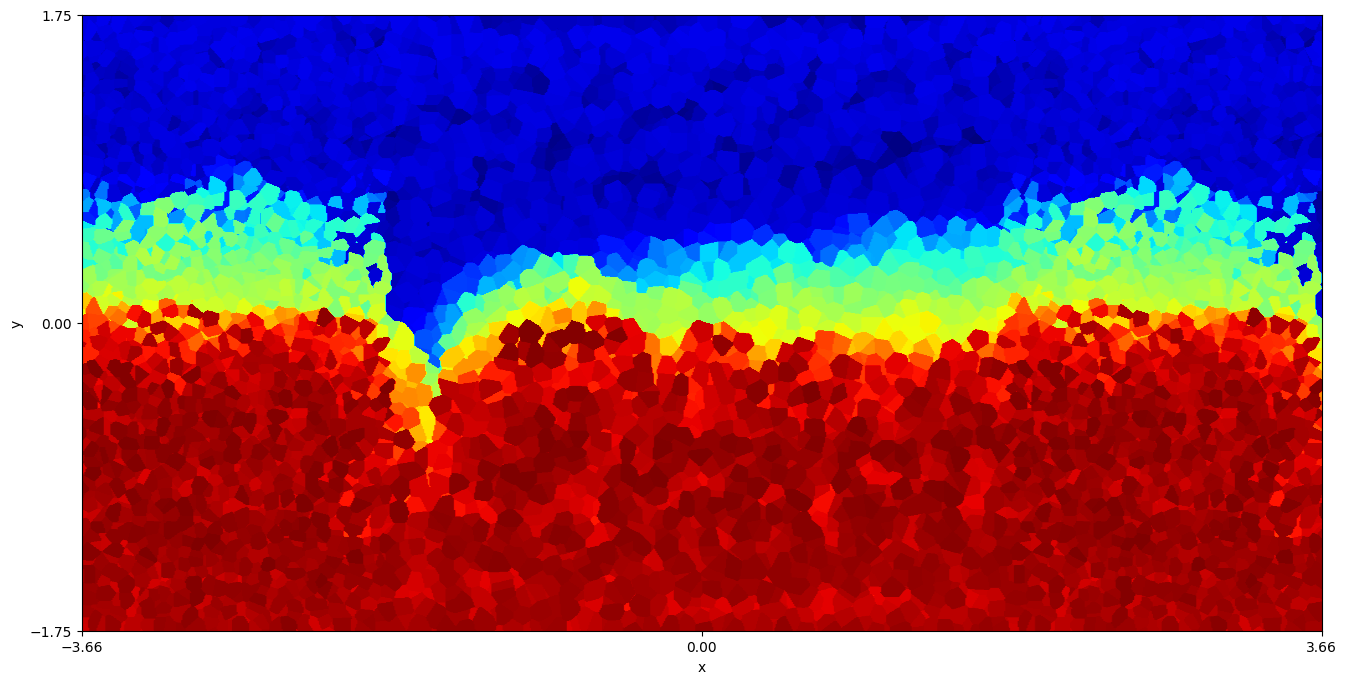

In [34]:
# Load in a package to preform a nearest neighbour search
from scipy.spatial import cKDTree

# Select the timestep you want to plot (e.g., 0 for the first timestep)
a, b, c = 3.66, 1.75, 0.45 # Pull in the dimensions of the fundamental domain
selected_timestep = 2 * 192  # Adjust this as needed 192, 384, 576, 768, 960, 1200
fixed_z = c # Set height we are ploting the temperature or total velocity at

# First we compute the temperature and zip it to the corresponding centroid
_, _, _, T, _, _ = aux.get_properties(Z, C, TC)
T_selected = T[selected_timestep, :, np.newaxis]  # T for selected timestep
C_selected = C[selected_timestep]  # Positions for selected timestep
CT_selected = np.concatenate((C_selected, T_selected), axis=1)  # Combine selected positions and temperatures

# Set the shift value to ensure that the copies lie in [-2a,-a] and [a,2a]
x_shift = 1.5 * a 
C_rs_selected = CT_selected.copy()
C_ls_selected = CT_selected.copy()
C_rs_selected[:, 0] += x_shift
C_ls_selected[:, 0] -= x_shift

# Combine the original and the two shifted centroid positions
combined_positions = np.vstack((CT_selected, C_rs_selected, C_ls_selected))

# Next we generate a grid containing all of the points on the surface or the lid for our contour plot. 

# Grid dimensions in x and y directions
num_points_x = 1000  # Number of points in x
num_points_y = 1000   # Number of points in y

# Generate grid points for x and y
x = np.linspace(-a, a, num_points_x)
y = np.linspace(-b, b, num_points_y)

# Create meshgrid for x and y
x_grid, y_grid = np.meshgrid(x, y)

# Flatten the x and y grid arrays
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Set the z coordinate
z_flat = np.full_like(x_flat, fixed_z)  # Create an array filled with the fixed z value

# Combine x, y, and z into a Mx3 matrix
sample_points = np.vstack((x_flat, y_flat, z_flat)).T

# Nearest neighbor search for the selected timestep
tree = cKDTree(combined_positions[:, :3])  # Use positions only
distances, indices = tree.query(sample_points, k=1)
nearest_temperatures = combined_positions[indices, 3]

# Prepare sample points with temperature for plotting
sample_points_with_temp = np.hstack((sample_points, nearest_temperatures[:, np.newaxis]))
xy_temp = sample_points_with_temp[:, [0, 1, 3]]

# Reshaping and plotting as before
temperatures_grid = xy_temp[:, 2].reshape((num_points_y, num_points_x))
x_unique = np.unique(xy_temp[:, 0])
y_unique = np.unique(xy_temp[:, 1])

plt.figure(figsize=(16, 8))

# Plot the contour without showing the colorbar
cp = plt.contourf(x_unique, y_unique, temperatures_grid, cmap='jet', levels=1000)

# Remove the colorbar by commenting it out or not using it
# plt.colorbar(cp)  # This line is commented out to hide the colorbar

# Set the title to None to hide it
plt.title(None)

# Set x and y axis ticks to the desired values
plt.xticks([-3.66, 0, 3.66])
plt.yticks([-1.75, 0, 1.75])

# Fix the color bar's min and max limits
#cp.set_clim(vmin=0, vmax=1.4)  # Adjust these values if needed

# Label the axes
plt.xlabel('x')
plt.ylabel('y')

# Display the plot
plt.show()

# # Calculate day number
# day_id = selected_timestep // 96  # Using integer division to get whole number days

# # Save the figure
# filename = f'Temp_Slice_day_{day_id}_3D.png'
# plt.savefig(filename, dpi=300)

In [20]:
print(np.shape(T))

(2413, 32768)
